The problem described in the test is essentially a classification problem for two classes (Fields and roads).

"Don't use a sledgehammer to crack a nut". There is no need to craft and theorize a top tier state of art model to crack this problem. Hence the classic selection of ResNet50 architecture that is already well known for its capabilities as a feature extracted with its residual mappings. The model, ressources wise, doesn't consume too much, good for embedded systems and doesnt require much implementation wise. The weights for the public model are available which gives us the chance to finetune the model for our problem. 

In [2]:
import torch
import os
from torchvision.datasets import ImageFolder  # for working with classes and images
import torchvision.transforms as transforms   # for transforming images into tensors 
from torch.utils.data import DataLoader, random_split
import numpy as np
from torchsummary import summary 
from torchvision.utils import make_grid       # for data checking
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
from torchvision.models import resnet50
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

# Setting the seed value
random_seed = 7
torch.manual_seed(random_seed)

# Training parameters
batch_size = 16
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4


The data has been a little organized manually into 2 directories train and test. Train folder already has folder classes with images accordingly separated, as for the Test folder it had to be done manually as well. 

|       | Roads | Fields |
|-------|-------|--------|
| train | 108   | 45     |
| test  | 6     | 4      |


There is no metadata associated to images to run further more statistics on the dataset.

In [12]:
path = os.getcwd()
valid_size = 0.1

path = os.getcwd()
all_data_dir = f"{path}{os.sep}dataset/"
classes = os.listdir(f"{all_data_dir}{os.sep}train")

# train data loading
train_data = ImageFolder(f"{all_data_dir}{os.sep}train", transform= transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]))

# test data loading
test_data = ImageFolder(f"{all_data_dir}{os.sep}test", transform= transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]))

# Train, val split for the loaded data
n_val = int(np.floor(valid_size * len(train_data)))
n_train = len(train_data) - n_val
train, valid = random_split(train_data, [n_train, n_val])


# Creating torch dataloaders for torch model
train_data = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_data = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)
test_data = DataLoader(test_data, 1, num_workers=2, pin_memory=True)

dataloaders = {"train":train_data, "val":valid_data}
image_datasets = {"train":train, "val":valid}

As explained above. ResNet50 choice was in relation to the simplicity and the requirements for the problem at hand. 
My laptop runs an Nvidia GTX1050 6GO vram able to load and retrain this model. surely other architecture might have been better or more suitable overall for classification task, but ResNet50 delivers results plenty good.

In [5]:
# Device selection
device = torch.device("cpu")
if torch.cuda.is_available:
    device = torch.device("cuda")

# Model loading
model = resnet50(pretrained=True).to(device)

def train_model(model, criterion, optimizer, num_epochs=3):
    """
        Method to run training steps for the model.
            model: nn.Module torch model
            criterion: Loss function.
            Optimizer: learning rate optimizer
            num_epochs: number of iteration to run the training for.
        returns metrics history recorded during training, the model with post training weights. 
    """

    history = {"train":{"loss":[], "acc":[]}, "val":{"loss":[], "acc":[]}}
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])
            history[phase]["loss"].append(epoch_loss)
            history[phase]["acc"].append(epoch_acc)
            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return history, model

Training phase is almost standard. The loss is of course CrossEntropy for multi class classification. 
The optimizer is SGD with a max learning rate of 0.01 and a random initialization. the weight decay is set at 1e-4.
The metric to evaluate is accuracy.


Notice how the model s validation accuracy is almost stable, which is due to the fact that we used a pretrained model.
The training loss indicates a pretty standard training no over/under fitting. The evaluation of the model against the test set yields a precision of 90%. 

Epoch 1/20
----------
train loss: 0.0660, acc: 0.9855
val loss: 0.0582, acc: 1.0000
Epoch 2/20
----------
train loss: 0.0609, acc: 0.9638
val loss: 0.0214, acc: 1.0000
Epoch 3/20
----------
train loss: 0.0851, acc: 0.9638
val loss: 0.0295, acc: 1.0000
Epoch 4/20
----------
train loss: 0.1802, acc: 0.9348
val loss: 0.0432, acc: 1.0000
Epoch 5/20
----------
train loss: 0.0665, acc: 0.9710
val loss: 0.0651, acc: 1.0000
Epoch 6/20
----------
train loss: 0.1192, acc: 0.9420
val loss: 0.0287, acc: 1.0000
Epoch 7/20
----------
train loss: 0.0947, acc: 0.9710
val loss: 0.0242, acc: 1.0000
Epoch 8/20
----------
train loss: 0.0942, acc: 0.9710
val loss: 0.0316, acc: 1.0000
Epoch 9/20
----------
train loss: 0.0452, acc: 0.9855
val loss: 0.0429, acc: 1.0000
Epoch 10/20
----------
train loss: 0.0685, acc: 0.9783
val loss: 0.0436, acc: 1.0000
Epoch 11/20
----------
train loss: 0.0714, acc: 0.9710
val loss: 0.0203, acc: 1.0000
Epoch 12/20
----------
train loss: 0.0318, acc: 1.0000
val loss: 0.0316, a

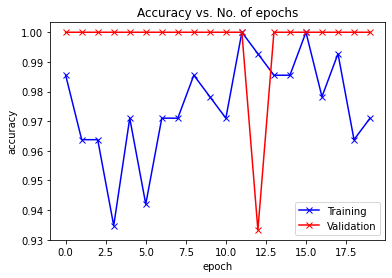

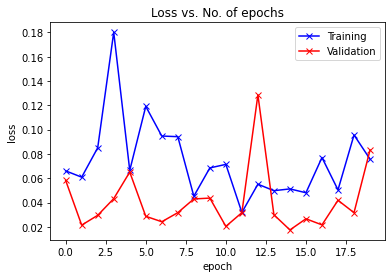

Label: roads , Predicted: roads
Test on 10 images, Accuracy evaluated at 0.800000


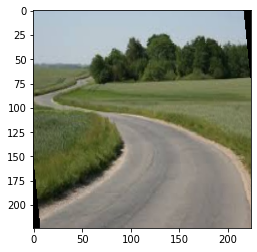

In [16]:
# Define parameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), max_lr, weight_decay=weight_decay)

history, model = train_model(model, criterion, optimizer, 20)

# plotting results
val_accuracies = [x.cpu() for x in history["val"]['acc']]
train_accuracies = [x.cpu() for x in history["train"]['acc']]
plt.plot(train_accuracies, '-bx')
plt.plot(val_accuracies, '-rx')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Training', 'Validation'])
plt.title('Accuracy vs. No. of epochs')
plt.show()

train_losses = [x for x in history['train']['loss']]
val_losses = [x for x in history['val']['loss']]
plt.plot(train_losses, '-bx')
plt.plot(val_losses, '-rx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. No. of epochs')
plt.show()


# Evaluating the model against the test set.
correct_predictions = 0
for _, t in enumerate(test_data):
    image, label = t
    image = image.cuda()
    pred_label = model(image)
    pred_label = torch.argmax(pred_label, dim=1)
    correct_predictions += int(pred_label.item() == label)
    
plt.imshow(image.cpu().squeeze(0).permute(1, 2, 0).clamp(0, 1))
print('Label:', classes[label], ', Predicted:', classes[pred_label])

test_accuracy = correct_predictions / len(test_data)
print("Test on {} images, Accuracy evaluated at {:f}".format(len(test_data), test_accuracy))

# saving the entire model to working directory
torch.save(model, f'{path}{os.sep}Bilberry-classification-model-ResUnet.pth')